In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import importlib
import tools.pltw as pltw

def reload_modules():
    importlib.reload(pltw)


In [4]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# Tools
---

In [5]:
def analyze_process_reassignments(df):
    # Count how many times each process was moved
    process_moves = df['ProcessID'].value_counts()

    print(f"Most frequently moved processes:")
    print(process_moves.head(10))
    
    print(f"\nMovement distribution:")
    print(f"Processes moved once: {sum(process_moves == 1)}")
    print(f"Processes moved 2-5 times: {sum((process_moves >= 2) & (process_moves <= 5))}")
    print(f"Processes moved >5 times: {sum(process_moves > 5)}")
    print(f"Max moves for single process: {process_moves.max()}")
    
    return process_moves


In [6]:
def show_reassignments_summary(df):
    print(f"Total reassignments: {len(df)}")
    print(f"Unique processes moved: {df['ProcessID'].nunique()}")
    print(f"Unique source machines: {df['SourceMachine'].nunique()}")
    print(f"Unique destination machines: {df['DestMachine'].nunique()}")
    print(f"Unique solutions: {df['SolutionId'].nunique()}")
    print(f"Initial solution cost: {df['SolutionCost'].iloc[0]}")
    print(f"Final solution cost: {df['SolutionCost'].iloc[-1]}")
    print(f"Cost improvement: {df['SolutionCost'].iloc[0] - df['SolutionCost'].iloc[-1]}")


# Approach by Jaskowski et al.
---

In [12]:
df_jask = pd.read_csv(
    '/home/pbiel/repos/mrp/jask/accepted_reassignments.csv',
    converters={
        'ProcessResourceRequirements': ast.literal_eval,
    }
)
df_jask['ProcessSize'] = df_jask['ProcessResourceRequirements'].apply(sum)

print(f"Solution contains {len(df_jask)} reassignments.")
df_jask.head()


Solution contains 330 reassignments.


,MoveNum,ProcessID,SourceMachine,DestMachine,OriginalMachine,Service,MoveCost,ProcessResourceRequirements,Improvement,Timestamp,...,SourceMachineCapacities,DestMachineCapacities,SourceMachineTransientUsage,DestMachineTransientUsage,SourceMachineProcessCount,DestMachineProcessCount,LoadCost,BalanceCost,SolutionCost,ProcessSize
0,1,138,53,76,53,141,1,"[621123, 391575, 25988, 3787006]",2.4285,1755082780577,...,"[3135647,3285240,1668729,10776271]","[2674055,2045617,3245821,7644847]","[0,0,0,10764554]","[0,0,0,4919106]",16,12,1035867720,0,1035867931,4825692
1,2,780,47,60,47,769,1,"[386106, 346913, 22844, 1338795]",3.8310,1755082780580,...,"[2821005,3137099,3083520,6584977]","[2513744,2131731,3885345,5158196]","[0,0,0,6584603]","[0,0,0,4519084]",14,16,1020977790,0,1020978102,2094658
2,3,807,38,31,38,795,1,"[631212, 347412, 6813, 769078]",5.4422,1755082780584,...,"[2328824,1520928,458113,5324291]","[1039346,1300298,1034346,1191742]","[0,0,0,5324291]","[0,0,0,836719]",9,4,1003872190,0,1003872703,1754515
3,4,54,75,46,75,61,1,"[745972, 749817, 639473, 401458]",6.9562,1755082780585,...,"[4459900,3475529,1698242,18159103]","[1540978,1177326,3555778,1463613]","[0,0,0,18159103]","[0,0,0,1014700]",14,9,987798210,0,987798824,2536720
4,5,129,57,71,57,132,1,"[379872, 295579, 1493, 1126371]",7.1665,1755082780586,...,"[2132781,2745036,807524,8354675]","[3415134,5358117,1717340,10941650]","[0,0,0,8354675]","[0,0,0,10828804]",12,14,985565180,0,985565995,1803315


- Using solution state change points clogs the plot - it occurs too often

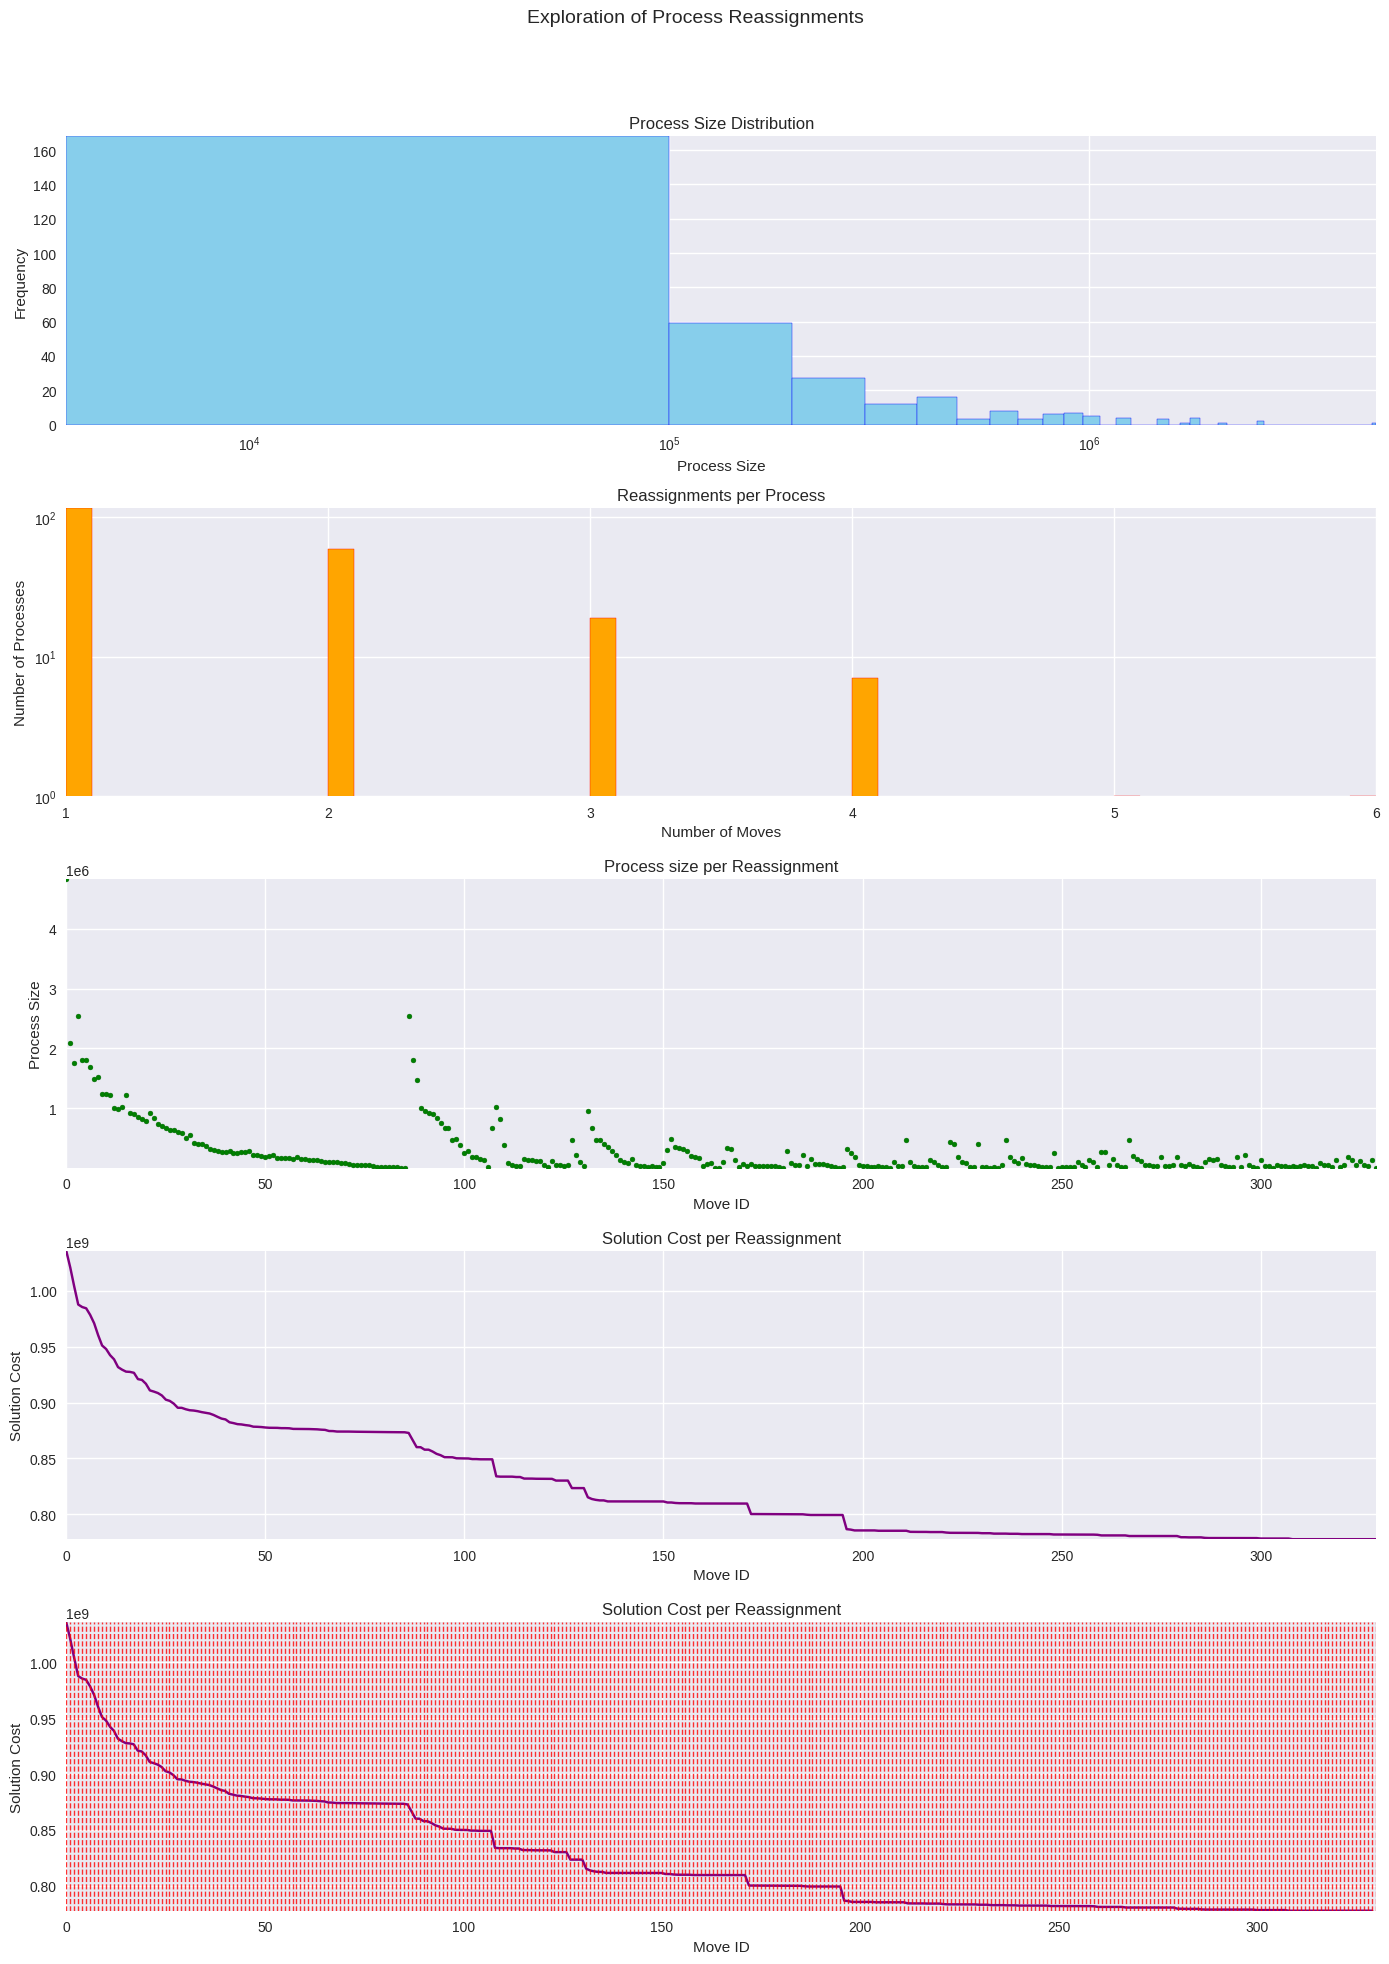

In [23]:
jask_reassignments = df_jask['ProcessID'].value_counts()

sol_mask = df_jask['SolutionId'].ne(df_jask['SolutionId'].shift()) # Boolean mask for solution ID changes
sol_change_points = sol_mask.index[sol_mask].tolist()  # Get indices where solution ID changes
sol_change_points = sol_change_points + [len(df_jask)]  # Include start and end of DataFrame

pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Process Size Distribution",
                  ylbl="Frequency",
                  xlbl="Process Size",
                  x=50,
                  y=df_jask['ProcessSize'],
                  kwargs={"color": 'skyblue', "edgecolor": 'blue', "ptype": 'hist', "xscale": 'log'}),

        pltw.plot(ttl="Reassignments per Process",
                  ylbl="Number of Processes",
                  xlbl="Number of Moves",
                  y=jask_reassignments.values,
                  x=50,
                  kwargs={"color": 'orange', "edgecolor": 'red', "ptype": 'hist', "yscale": 'log'}),

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df_jask['ProcessSize'],
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_jask['SolutionCost'],
                  kwargs={"color": 'purple'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_jask['SolutionCost'],
                  vlines=sol_change_points,
                  kwargs={"color": 'purple'}),
    ],
)


In [ ]:
show_reassignments_summary(df_jask)


Total reassignments: 330
Unique processes moved: 203
Unique source machines: 85
Unique destination machines: 71
Unique solutions: 330
Initial solution cost: 1035867931
Final solution cost: 777545063
Cost improvement: 258322868


In [7]:
df_jask_all = pd.read_csv(
    '/home/pbiel/repos/mrp/jask/process_reassignments.csv',
    converters={
        'ProcessResourceRequirements': ast.literal_eval,
    }
)
df_jask_all['ProcessSize'] = df_jask_all['ProcessResourceRequirements'].apply(sum)
print(f"Solution contains {len(df_jask_all)} reassignments.")
df_jask_all.head()


Solution contains 206485 reassignments.


,MoveNum,ProcessID,SourceMachine,DestMachine,OriginalMachine,Service,MoveCost,ProcessResourceRequirements,Improvement,Timestamp,...,SourceMachineCapacities,DestMachineCapacities,SourceMachineTransientUsage,DestMachineTransientUsage,SourceMachineProcessCount,DestMachineProcessCount,LoadCost,BalanceCost,SolutionCost,ProcessSize
0,1,138,53,76,53,141,1,"[621123, 391575, 25988, 3787006]",0.0000,1755082780575,...,"[3135647,3285240,1668729,10776271]","[2674055,2045617,3245821,7644847]","[0,0,0,10764554]","[0,0,0,1132100]",17,11,1061649570,0,1061649570,4825692
1,2,759,53,71,53,749,1,"[810461, 876255, 311104, 659257]",2.4285,1755082780578,...,"[3135647,3285240,1668729,10776271]","[3415134,5358117,1717340,10941650]","[0,0,0,10764554]","[0,0,0,9702433]",16,13,1035867720,0,1035867931,2657077
2,3,759,71,53,53,749,1,"[810461, 876255, 311104, 659257]",1.2379,1755082780578,...,"[3415134,5358117,1717340,10941650]","[3135647,3285240,1668729,10776271]","[0,0,0,10361690]","[0,0,0,10764554]",14,15,1048507290,0,1048507702,2657077
3,4,780,47,60,47,769,1,"[386106, 346913, 22844, 1338795]",2.4285,1755082780580,...,"[2821005,3137099,3083520,6584977]","[2513744,2131731,3885345,5158196]","[0,0,0,6584603]","[0,0,0,3180289]",15,15,1035867720,0,1035867931,2094658
4,5,550,47,71,47,542,1,"[399471, 511495, 97396, 962662]",3.8310,1755082780581,...,"[2821005,3137099,3083520,6584977]","[3415134,5358117,1717340,10941650]","[0,0,0,6584603]","[0,0,0,9702433]",14,13,1020977790,0,1020978102,1971024


In [8]:
jask_all_reassignments = analyze_process_reassignments(df_jask_all)


Most frequently moved processes:
ProcessID
362    582
423    579
994    578
513    576
809    573
916    572
724    564
346    564
132    563
893    561
Name: count, dtype: int64

Movement distribution:
Processes moved once: 2
Processes moved 2-5 times: 40
Processes moved >5 times: 838
Max moves for single process: 582


In [19]:
show_reassignments_summary(df_jask_all)


Total reassignments: 206485
Unique processes moved: 880
Unique source machines: 100
Unique destination machines: 100
Unique solutions: 428
Initial solution cost: 1061649570
Final solution cost: 777545261
Cost improvement: 284104309


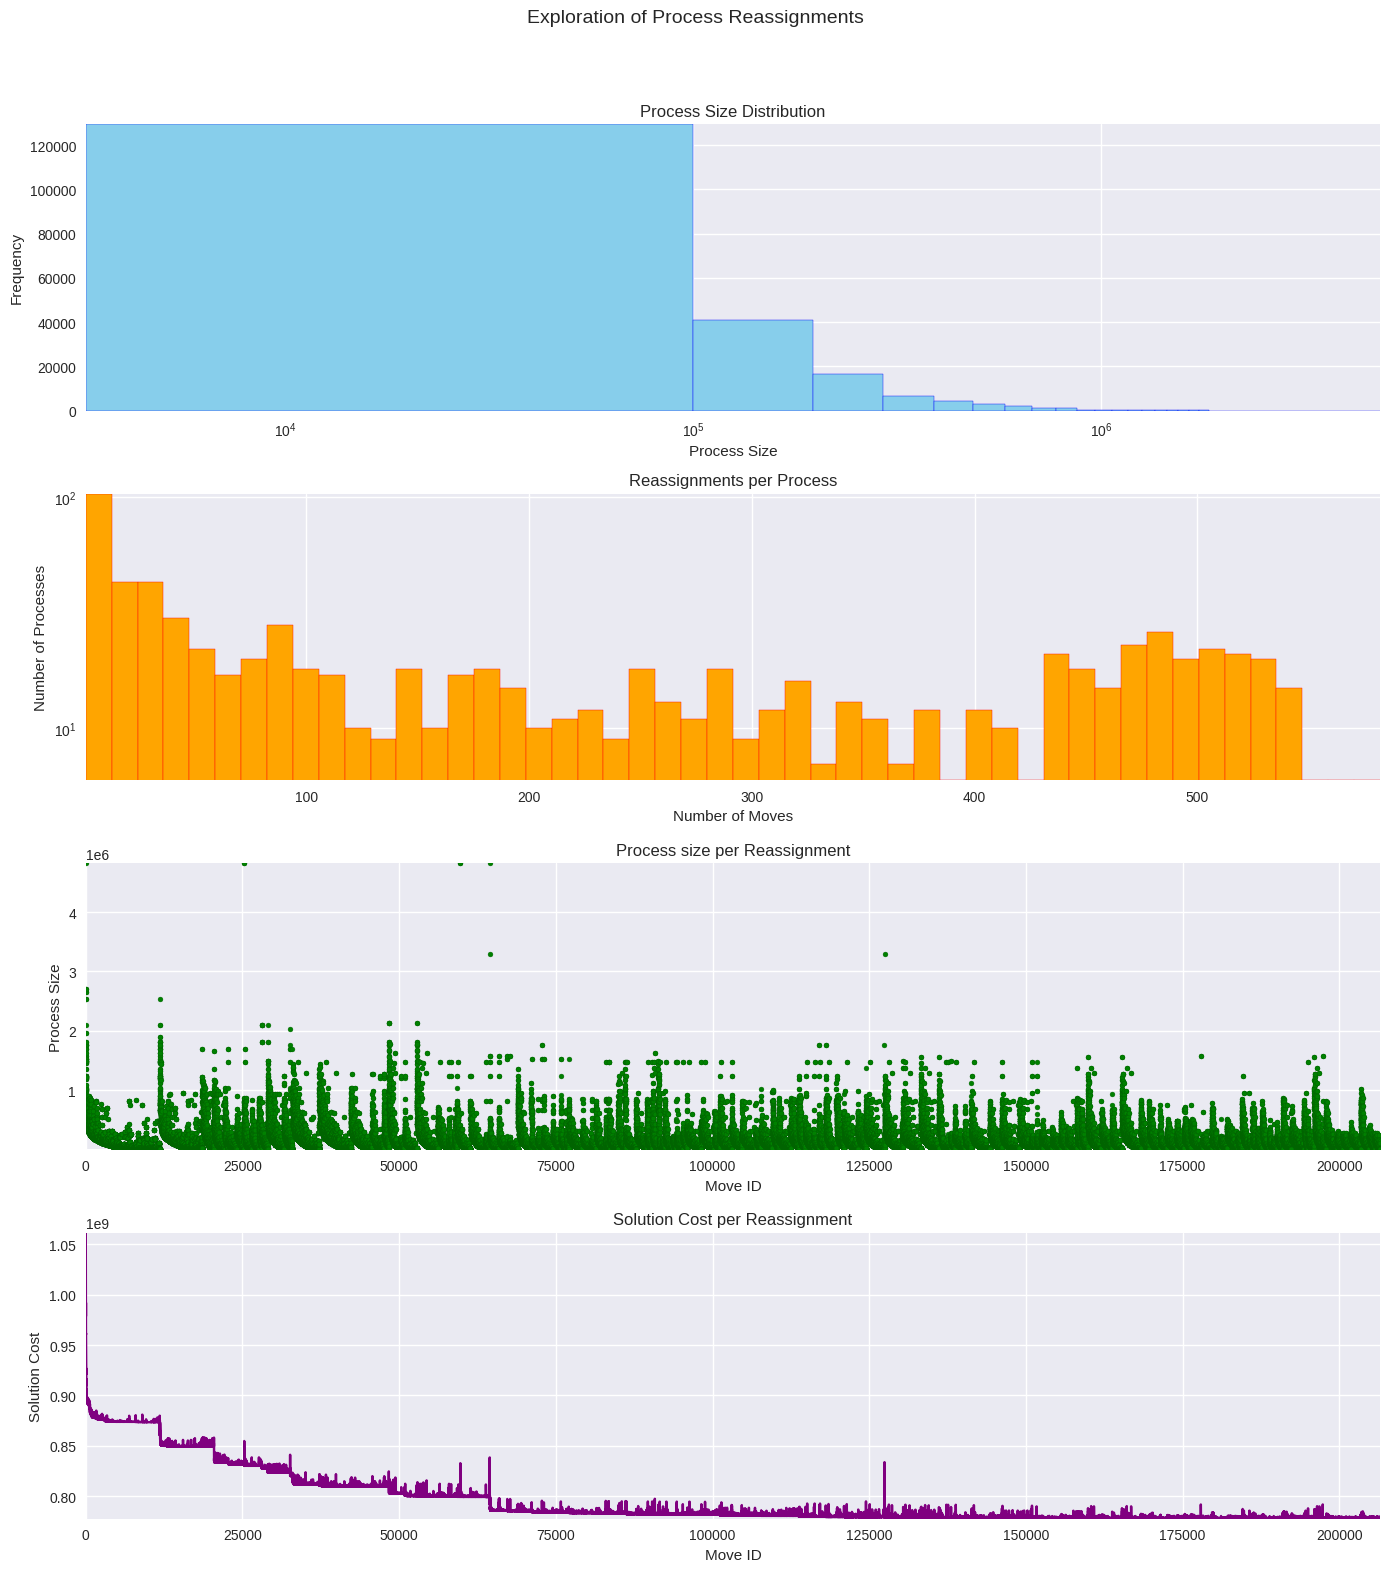

In [9]:
pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Process Size Distribution",
                  ylbl="Frequency",
                  xlbl="Process Size",
                  x=50,
                  y=df_jask_all['ProcessSize'],
                  kwargs={"color": 'skyblue', "edgecolor": 'blue', "ptype": 'hist', "xscale": 'log'}),

        pltw.plot(ttl="Reassignments per Process",
                  ylbl="Number of Processes",
                  xlbl="Number of Moves",
                  y=jask_all_reassignments.values,
                  x=50,
                  kwargs={"color": 'orange', "edgecolor": 'red', "ptype": 'hist', "yscale": 'log'}),

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df_jask_all['ProcessSize'],
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_jask_all['SolutionCost'],
                  kwargs={"color": 'purple'}),
    ],
)


Reduced to 25810 reassignments for analysis.
Solution change points: [0, 1, 4, 13, 15] ... [23672, 24592, 25284, 25705, 25810]


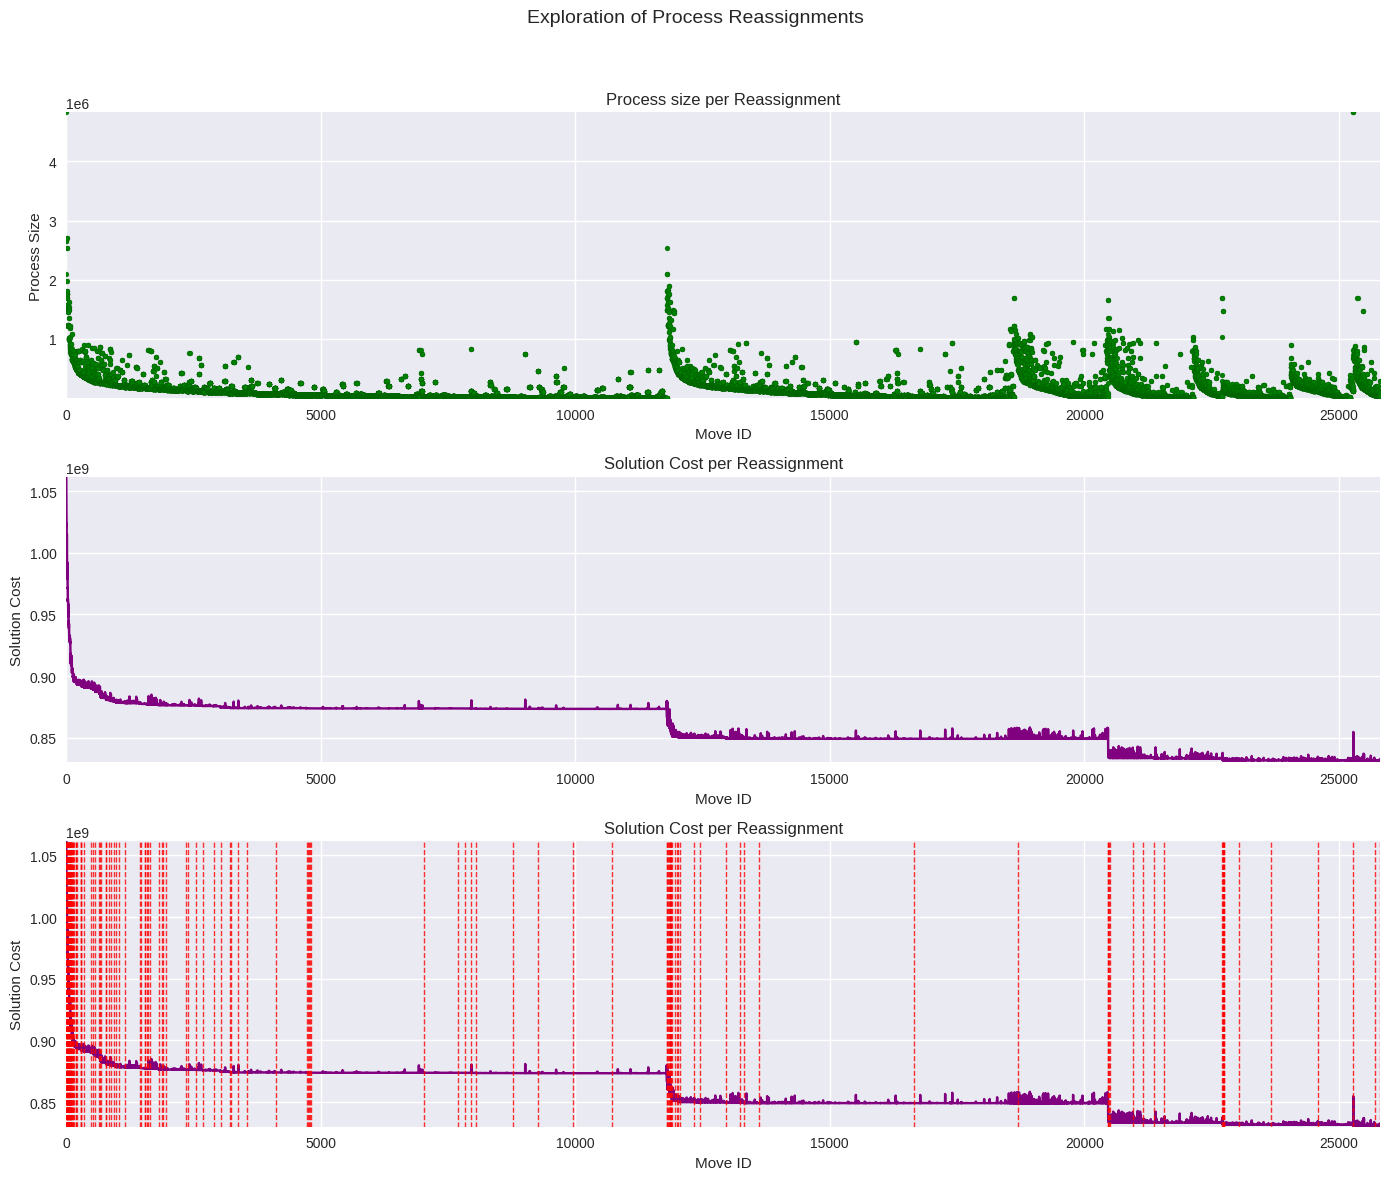

In [10]:
df_jask_partial = df_jask_all.iloc[:len(df_jask_all) // 8]
print(f"Reduced to {len(df_jask_partial)} reassignments for analysis.")

sol_mask = df_jask_partial['SolutionId'].ne(df_jask_partial['SolutionId'].shift()) # Boolean mask for solution ID changes
sol_change_points = sol_mask.index[sol_mask].tolist()  # Get indices where solution ID changes
sol_change_points = sol_change_points + [len(df_jask_partial)]  # Include start and end of DataFrame
print(f"Solution change points: {sol_change_points[:5]} ... {sol_change_points[-5:]}")

pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df_jask_partial['ProcessSize'],
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_jask_partial['SolutionCost'],
                  kwargs={"color": 'purple'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_jask_partial['SolutionCost'],
                  vlines=sol_change_points,
                  kwargs={"color": 'purple'}),
    ],
)


# Approach by Gavranovic et al.
---

In [ ]:
df_gavra = pd.read_csv(
    '/home/pbiel/repos/mrp/gavra/Releasegcc/accepted_reassignments_sol1.csv',
    converters={
        'ProcessResourceRequirements': ast.literal_eval,
    }
)
df_gavra['ProcessTotalReq'] = df_gavra['ProcessResourceRequirements'].apply(sum)

print(f"Solution contains {len(df_gavra)} reassignments.")
df_gavra.head()

# Only use first 25% of the data for analysis
# df = df.iloc[:len(df) // 4]
# print(f"Reduced to {len(df_gavra)} reassignments for analysis.")


Solution contains 4344 reassignments.


,MoveNum,ProcessID,SourceMachine,DestMachine,OriginalMachine,Service,MoveCost,ProcessResourceRequirements,Improvement,Timestamp,...,SourceMachineCapacities,DestMachineCapacities,SourceMachineTransientUsage,DestMachineTransientUsage,SourceMachineProcessCount,DestMachineProcessCount,LoadCost,BalanceCost,SolutionCost,ProcessTotalReq
0,1,1,8,14,48,8,1,"[35574, 21914, 48459]",0.0,1755087615000,...,"[2344071,3031239,3573218]","[3233735,3655313,8642089]","[1759408,2076047,3059201]","[2737196,2642254,8566626]",12,34,395942500,2426474200,2823506710,105947
1,2,2,0,11,34,17,1,"[6429, 4024, 17106]",0.0,1755087615000,...,"[722040,645675,789895]","[2972420,2877021,6716092]","[624553,488000,754104]","[2871011,2688144,6723251]",11,19,396330900,2426474200,2823895110,27559
2,3,6,16,47,16,2,1,"[171832, 137485, 49123]",0.0,1755087615000,...,"[4087795,4462350,9561546]","[6578597,7775116,14119786]","[3261202,3022402,8608708]","[5779889,7051162,14027127]",16,29,413013500,2426474200,2840579720,358440
3,4,9,47,32,47,81,1,"[3738, 1896, 2877]",0.0,1755087615000,...,"[6578597,7775116,14119786]","[4944858,5498738,7857445]","[5776151,7049266,14027127]","[4373714,4377855,7858431]",28,21,412829300,2426474200,2840397530,8511
4,5,11,26,20,14,4,1,"[421150, 835413, 82703]",0.0,1755087615000,...,"[2940295,3772766,10030869]","[4566377,6030697,13558852]","[1650034,1957009,9936272]","[3815227,5757139,13530853]",9,13,524503900,2426474200,2952072130,1339266


In [ ]:
show_reassignments_summary(df_gavra)


Total reassignments: 4344
Unique processes moved: 842
Unique source machines: 50
Unique destination machines: 50
Unique solutions: 8
Initial solution cost: 2823506710
Final solution cost: 2768705380
Cost improvement: 54801330


Analysis into:
- Process distribution by size
- Process reassignments distribution by size
- Process reassignments over solution
- Solution Cost across reassignments
- Solution Cost Improvement across reassignments

In [96]:
# Get unique process sizes by process ID
unique_process_sizes = df.groupby('ProcessID')['ProcessTotalReq'].first().reset_index()
print(f"Unique process sizes:\n{unique_process_sizes}")

process_size_quantiles = unique_process_sizes['ProcessTotalReq'].quantile([0.25, 0.5, 0.75, 1.0])
print(f"Process size quantiles:\n{process_size_quantiles}")

# Calculate portion of processes under 25% quantile
process_under_25 = unique_process_sizes[unique_process_sizes['ProcessTotalReq'] < process_size_quantiles[0.25]]
print(f"Processes under 25% quantile ({process_size_quantiles[0.25]}): {len(process_under_25)} out of {len(unique_process_sizes)}")
print(f"Size {process_size_quantiles[0.25]} is {process_size_quantiles[0.25] / unique_process_sizes['ProcessTotalReq'].max() * 100:.2f}% of the largest process size ({unique_process_sizes['ProcessTotalReq'].max()})")


Unique process sizes:
   ProcessID  ProcessTotalReq
0          1           860648
1         28           729579
2         34           584451
3         35           506071
4         36          1005296
5         58          1662580
6         74          1141047
7         94           971475
8         95          1198814
Process size quantiles:
0.25     729579.0
0.50     971475.0
0.75    1141047.0
1.00    1662580.0
Name: ProcessTotalReq, dtype: float64
Processes under 25% quantile (729579.0): 2 out of 9
Size 729579.0 is 43.88% of the largest process size (1662580)


Most frequently moved processes:
ProcessID
518    8
516    8
976    8
959    8
951    8
555    8
554    8
140    8
138    8
90     8
Name: count, dtype: int64

Movement distribution:
Processes moved once: 65
Processes moved 2-5 times: 331
Processes moved >5 times: 446
Max moves for single process: 8


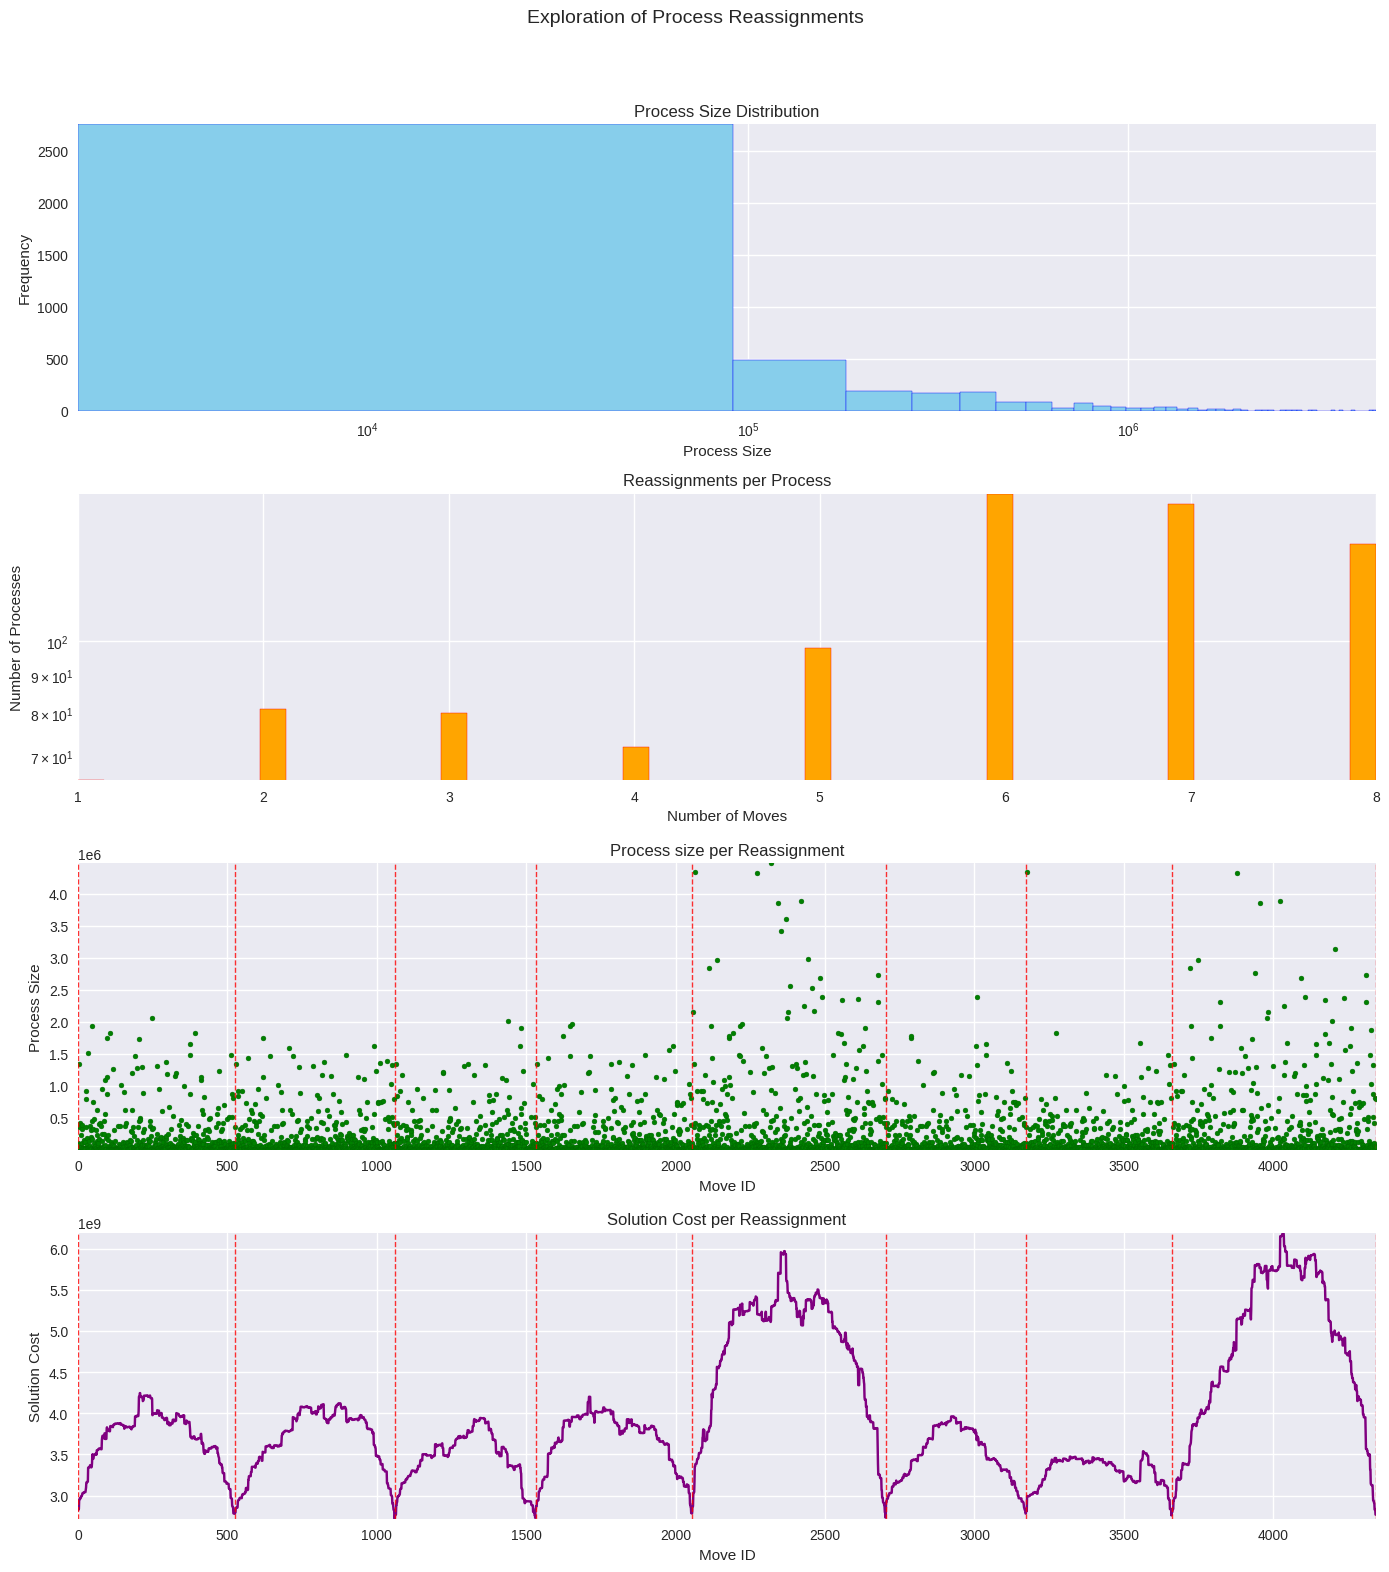

In [20]:
process_reassignments = analyze_process_reassignments(df_gavra)
sol_mask = df_gavra['SolutionId'].ne(df_gavra['SolutionId'].shift()) # Boolean mask for solution ID changes
sol_change_points = sol_mask.index[sol_mask].tolist()  # Get indices where solution ID changes
sol_change_points = sol_change_points + [len(df_gavra)]  # Include start and end of DataFrame

pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Process Size Distribution",
                  ylbl="Frequency",
                  xlbl="Process Size",
                  x=50,
                  y=df_gavra['ProcessTotalReq'],
                  kwargs={"color": 'skyblue', "edgecolor": 'blue', "ptype": 'hist', "xscale": 'log'}),

        pltw.plot(ttl="Reassignments per Process",
                  ylbl="Number of Processes",
                  xlbl="Number of Moves",
                  y=process_reassignments.values,
                  x=50,
                  kwargs={"color": 'orange', "edgecolor": 'red', "ptype": 'hist', "yscale": 'log'}),

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df_gavra['ProcessTotalReq'],
                  vlines=sol_change_points,
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_gavra['SolutionCost'],
                  vlines=sol_change_points,
                  kwargs={"color": 'purple'}),
    ],
)


- Solution state changes

# Approach by Mehta et al.
---

In [21]:
df_mehta = pd.read_csv('/home/pbiel/repos/mrp/mehta/cblns/reassignment_a1_4.txt_tracking.csv')
lookup = (
    df_jask[['ProcessID', 'ProcessSize']]
    .drop_duplicates('ProcessID')
    .set_index('ProcessID')['ProcessSize']
)
df_mehta = df_mehta.copy()
df_mehta['ProcessSize'] = df_mehta['processId'].map(lookup)
df_mehta['ProcessSize'] = df_mehta['ProcessSize'].fillna(0).astype(int)

print(f"Solution contains {len(df_mehta)} reassignments.")
df_mehta.head()


Solution contains 25440 reassignments.


,moveNumber,processId,sourceMachine,destMachine,moveCost,improvement,timestamp,solutionId,solutionCost,ProcessSize
0,1,973,20,47,0,0,0.0,1,601689777,0
1,2,378,20,47,0,0,0.0,1,601689777,0
2,3,756,20,12,0,0,0.0,1,601689777,192122
3,4,844,20,33,0,0,0.0,1,601689777,0
4,5,638,20,38,0,0,0.0,1,601689777,52549


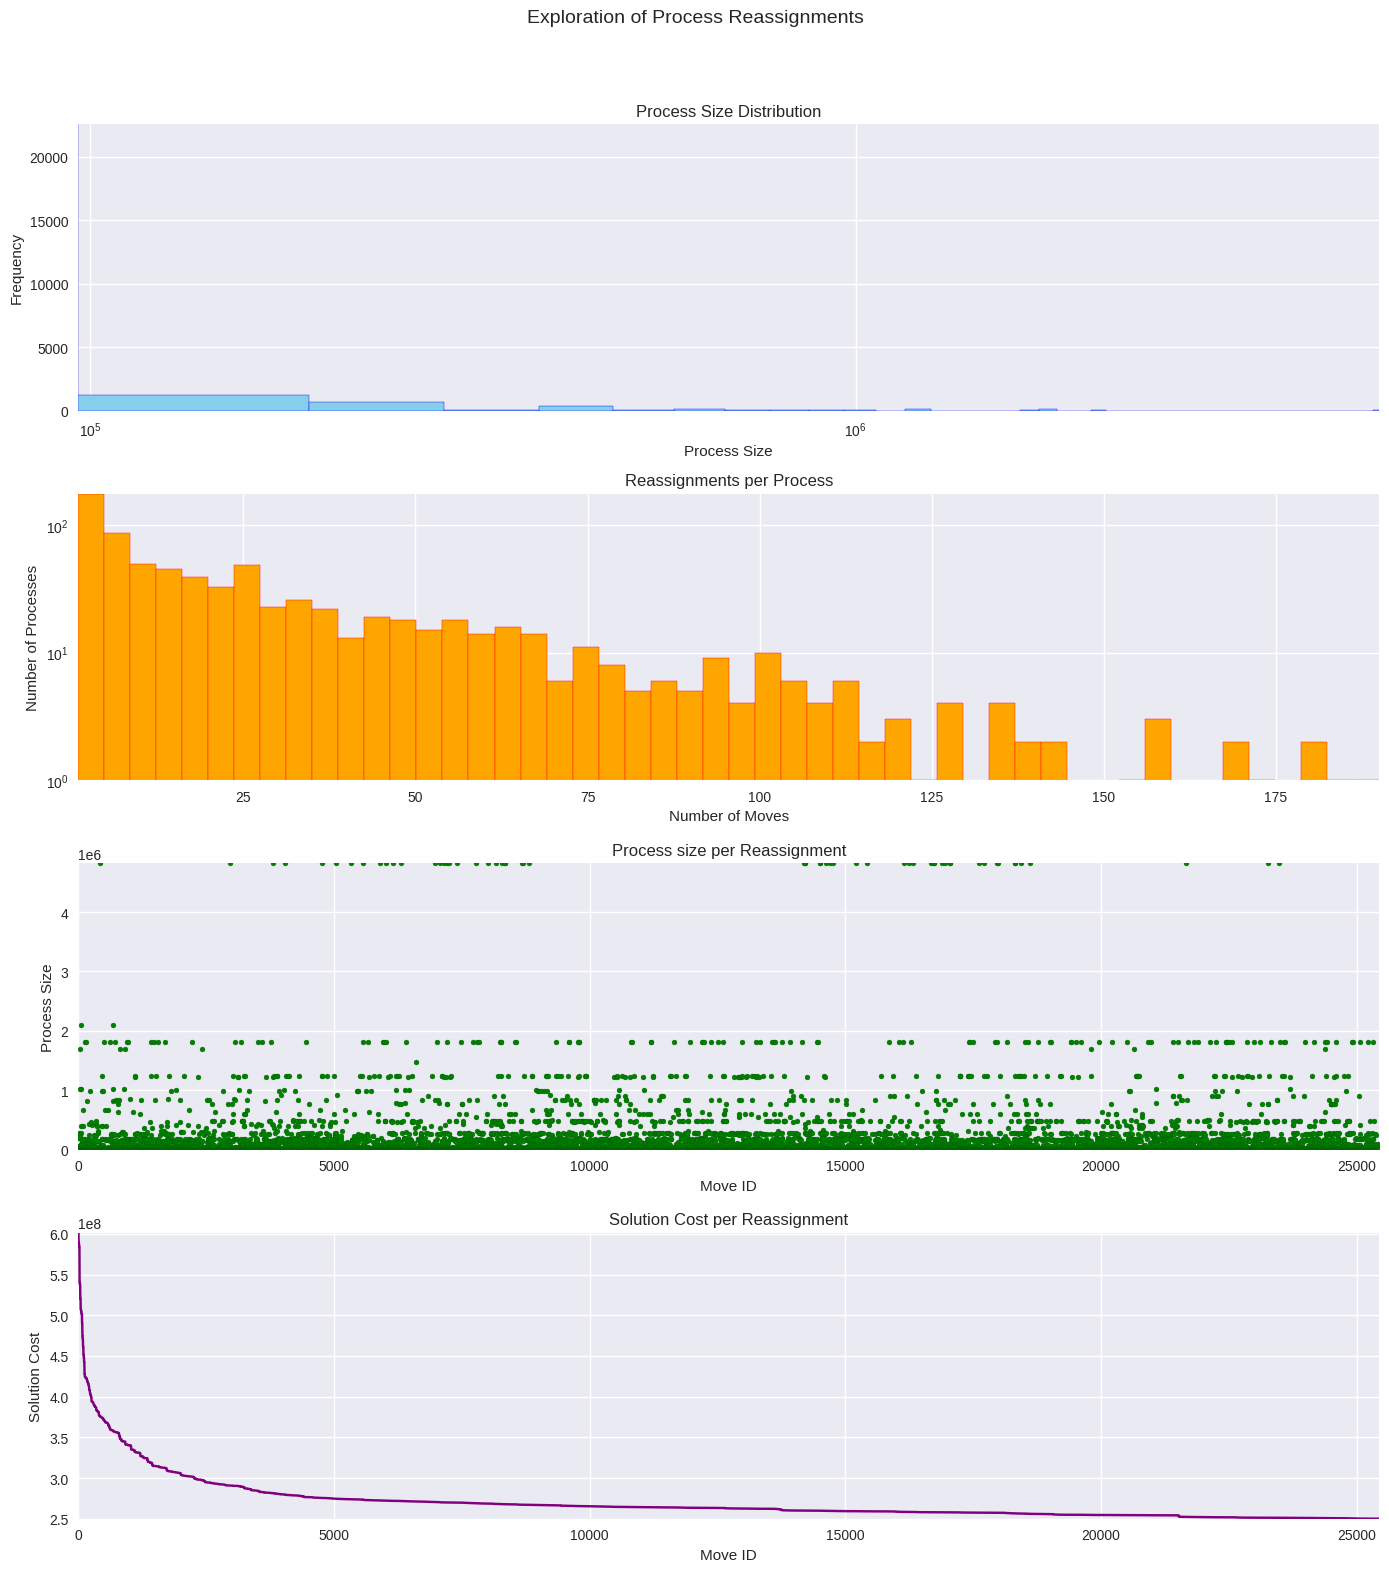

In [22]:
process_reassignments = df_mehta['processId'].value_counts()

pltw.fig(
    ttl="Exploration of Process Reassignments",
    plots=[
        pltw.plot(ttl="Process Size Distribution",
                  ylbl="Frequency",
                  xlbl="Process Size",
                  x=50,
                  y=df_mehta['ProcessSize'],
                  kwargs={"color": 'skyblue', "edgecolor": 'blue', "ptype": 'hist', "xscale": 'log'}),

        pltw.plot(ttl="Reassignments per Process",
                  ylbl="Number of Processes",
                  xlbl="Number of Moves",
                  y=process_reassignments.values,
                  x=50,
                  kwargs={"color": 'orange', "edgecolor": 'red', "ptype": 'hist', "yscale": 'log'}),

        pltw.plot(ttl="Process size per Reassignment",
                  ylbl="Process Size",
                  xlbl="Move ID",
                  y=df_mehta['ProcessSize'],
                  kwargs={"color": 'green', "edgecolor": 'darkgreen', "ptype": 'scatter', "marker": '.'}),

        pltw.plot(ttl="Solution Cost per Reassignment",
                  ylbl="Solution Cost",
                  xlbl="Move ID",
                  y=df_mehta['solutionCost'],
                  kwargs={"color": 'purple'}),
    ],
)
